In [1]:
from SALib.sample import latin, sobol
import pandas as pd
import numpy as np

### Sampling

##### 1. Model inputs

In [10]:
# Number of Samples
nsamples = 16 

# Number of parameters
nparams = 2 

#Ranges for each parameter
'''param_ranges = {
    'cell_ecm_repulsion': [0, 75],
    'contact_cell_ECM_threshold': [0, 2],
    'contact_cell_cell_threshold': [0, 3.5],
    'cell_junctions_attach_threshold': [0, 1],
    'cell_junctions_detach_threshold': [0, 1],
    'migration_bias': [0, 1],
    'migration_speed': [0, 1],
    'persistence': [0, 100]
}

#Define the problem for SALib
problem = {
    'num_vars': nparams,
    'names': list(param_ranges.keys()),
    'bounds': [[0, 75], [0, 2], [0, 3.5], [0, 1], [0, 1], [0, 1], [0, 1], [0, 100]] 
}'''

param_ranges = {
    'cell_cell_repulsion_strength': [1, 10],
    'cell_cell_adhesion_strength': [0, 0.6]
}

#Define the problem for SALib
problem = {
    'num_vars': nparams,
    'names': list(param_ranges.keys()),
    'bounds': [[1, 10], [0, 0.6]] 
}

##### 2. Generate samples

In [11]:
#Generate sobol samples
sobol_samples = sobol.sample(problem, nsamples)

##### 3. Save output 

In [12]:
param_names = list(param_ranges.keys())
sobol_samples = pd.DataFrame(sobol_samples, columns=param_names)

#Save output
sobol_samples.to_csv('sobol_samples.csv', index=False)

##### 4. Generate subspace

In [5]:
data = pd.read_csv('lhs_samples.csv')
num_files = 4
rows = int(len(data)/num_files)

# Loop over the number of output files to generate
for i in range(num_files):
    # Calculate the start and end indices for the current output file
    start_idx = i * rows
    end_idx = (i + 1) * rows

    # If this is the last file, include any remaining rows
    if i == num_files - 1:
        end_idx = len(data)

    # Extract the rows for the current output file
    subset = data.iloc[start_idx:end_idx]

    # Write the rows to a new CSV file
    filename = f'saltelli_samples_{i}.csv'
    subset.to_csv(filename, index=False)

### Parse XML

In [5]:
import xml.etree.ElementTree as ET
import subprocess

##### Load files

In [99]:
#Load samples from LHS or Sobol
samples_sobol = pd.read_csv('../data_output/sobol_samples.csv')
#Load xml file
tree = ET.parse('../output/NLC_CLL.xml')
root = tree.getroot()

##### Parameters

In [87]:
#param_names = {"cell_cell_repulsion_strength": 0, "cell_cell_adhesion_strength": 1, "relative_maximum_adhesion_distance": 2, 
#               "cell_BM_adhesion_strength": 3, "speed": 4, "migration_bias": 5, "secretion_rate": 6, "fluid_change_rate":7}
#param_names = {"cell_cell_repulsion_strength": 0, "cell_cell_adhesion_strength": 1}

#cell_names = {'cancer', 'cancer', 'cancer', 'monocytes', 'monocytes', 'macrophages', 'macrophages', 'NLCs', 'NLCs', 'NLCs'}
#param_names = {'uptake_rate': 0, 'speed': 1, 'transformation_rate': 2, 'speed': 3, 'dead_phagocytosis_rate': 4, 
#               'speed': 5,'dead_phagocytosis_rate': 6, 'secretion_rate': 7, 'speed': 8, 'dead_phagocytosis_rate': 9}

#updated_param_names = {tuple(param.split('_')): value for param, value in param_names.items()}

#print(updated_param_names)
#print(param_names.items())

#for param, value in param_names.items():
#    x = param.split('_')
#    print(x[len(x)-1])

param_names = {'uptake_rate_cancer': 0, 'speed_cancer': 1, 'transformation_rate_cancer': 2, 'speed_monocytes': 3, 
               'dead_phagocytosis_rate_monocytes': 4, 'speed_macrophages': 5,'dead_phagocytosis_rate_macrophages': 6, 
               'secretion_rate_NLCs': 7, 'speed_NLCs': 8, 'dead_phagocytosis_rate_NLCs': 9}



filtered_params = {param.replace('_cancer', '').replace('_monocytes', '').replace('_NLCs', ''): value
                   for param, value in param_names.items()}

print(filtered_params)


{'uptake_rate': 0, 'speed': 8, 'transformation_rate': 2, 'dead_phagocytosis_rate': 9, 'speed_macrophages': 5, 'dead_phagocytosis_rate_macrophages': 6, 'secretion_rate': 7}


In [155]:
param_behaviors = {'cancer':{'uptake_rate': 0, 'speed': 1, 'transformation_rate': 2},
                   'monocytes':{'speed': 3, 'dead_phagocytosis_rate': 4},
                   'macrophages':{'speed': 5, 'dead_phagocytosis_rate': 6},
                   'NLCs': {'secretion_rate': 7, 'speed': 8, 'dead_phagocytosis_rate': 9}}


#for celltype, celltype_param in param_behaviors.items():
#    print(celltype)
#    for param, column in celltype_param.items():
#        print(param)
#        print(column)
    
sobol_data = np.loadtxt('../data_output/sobol_samples.csv', delimiter=",", skiprows=1)

In [164]:
tree = ET.parse('../output/NLC_CLL.xml')
root = tree.getroot()
#celltype = 'NLCs'
#param = 'secretion_rate'
#param_element = root.findall(f".//*[@name='{celltype}']//*[@name='anti-apoptotic factor']//{param}")
#print(param_element[0].text)
#param_element = root.findall(".//*[@name='{celltype}'/phenotype/cell_interactions/dead_phagocytosis_rate")
#print(param_element)

celltype = 'cancer'
param = 'uptake_rate'
param_element = root.find(f".//*[@name='{celltype}']//*[@name='anti-apoptotic factor']//{param}") #Find the param name in XML file
print(param_element.text())

TypeError: 'str' object is not callable

In [165]:
for i, lhs_iteration in enumerate(sobol_data): #Taking rows where i = row number and lhs_iteration = list of parameters from corresponding row
    for celltype, celltype_param in param_behaviors.items(): #param_name = parameter name and lhs_col_index = column number
        for param, column in celltype_param.items():
            if(celltype == 'cancer' and param == 'uptake_rate'):
                param_value = lhs_iteration[column] #Extract each value [i, lhs_col_index]
                param_element = root.find(f".//*[@name='{celltype}']//*[@name='anti-apoptotic factor']//{param}") #Find the param name in XML file
                param_element.text = str(param_value)
            elif(celltype == 'cancer' and param == 'transformation_rate'):
                param_value = lhs_iteration[column] #Extract each value [i, lhs_col_index]
                param_element = root.find(f".//*[@name='{celltype}']//{param}/[@name='apoptotic']") #Find the param name in XML file
                param_element.text = str(param_value)
            elif(celltype == 'NLCs' and param == 'secretion_rate'):
                param_value = lhs_iteration[column] #Extract each value [i, lhs_col_index]
                param_element = root.find(f".//*[@name='{celltype}']//*[@name='anti-apoptotic factor']//{param}") #Find the param name in XML file
                param_element.text = str(param_value)
            else:
                param_value = lhs_iteration[column] #Extract each value [i, lhs_col_index]
                param_element = root.find(f".//*[@name='{celltype}']//{param}") #Find the param name in XML file
                param_element.text = str(param_value)
        
    # Write the updated XML to a string
    updated_xml_str = ET.tostring(root, encoding="unicode", method="xml")

In [167]:
print(updated_xml_str)

<PhysiCell_settings version="devel-version">

    <domain>
        <x_min>-900</x_min>
        <x_max>900</x_max>
        <y_min>-900</y_min>
        <y_max>900</y_max>
        <z_min>-10</z_min>
        <z_max>10</z_max>
        <dx>20</dx>
        <dy>20</dy>
        <dz>20</dz>
        <use_2D>true</use_2D>
    </domain>

    <overall>
        <max_time units="min">18720.0</max_time>
        <time_units>min</time_units>
        <space_units>micron</space_units>
        <dt_diffusion units="min">0.01</dt_diffusion>
        <dt_mechanics units="min">0.1</dt_mechanics>
        <dt_phenotype units="min">6</dt_phenotype>
    </overall>

    <parallel>
        <omp_num_threads>4</omp_num_threads>
    </parallel>

    <save>
        <folder>output</folder>
        <full_data>
            <interval units="min">60</interval>
            <enable>true</enable>
        </full_data>
        <SVG>
            <interval units="min">60</interval>
            <enable>true</enable>
            <plot_

In [132]:
#x = root.findall("./cell_definitions/cell_definition/phenotype/mechanics/cell_cell_adhesion_strength")
#x[0].text

cell_name = ['cancer', 'monocytes', 'NLCs']
param_name = 'uptake_rate'
x = root.findall(f".//*[@name='{cell_name[1]}']//{param_name}")
print(x[0].text)
print(cell_name[1])

0.0
monocytes


In [ ]:
tree = ET.parse('../output/NLC_CLL.xml')
root = tree.getroot()


##### Loop to update values in XML file

In [28]:
replicates = 5 #For bootstrapping
# Loop over each iteration in the LHS data
for i, lhs_iteration in enumerate(samples_lhs): #Taking rows where i = row number and lhs_iteration = list of parameters from corresponding row
# Loop over each parameter and update its value in the XML file
    for param_name, lhs_col_index in param_names.items(): # param_name = parameter name and lhs_col_index = column number
        param_value = lhs_iteration[lhs_col_index] #Extract each value [i, lhs_col_index]
        param_elements = root.findall(f".//{param_name}") #Find the param name in XML file
        for param_element in param_elements:
            param_element.text = str(param_value) #Update the text of xml file with extracted value 

    #To fix: root.find is not finding all elements that match with param_name, only is replacing in the first one (FIX!)
    #if updated_xml_str is outside this for is because all the set of input variables are being replacing in the xml file at once
        
    # Write the updated XML to a string
    updated_xml_str = ET.tostring(root, encoding="unicode", method="xml")

    # Define the command to call your C++ software with the updated XML as input
    command = ["./project", "./config/NLC_CLL.xml"]
    stdin_str = updated_xml_str

    for i in range(replicates): #replicates is for bootstrapping, we run the simulation with updated value # (replicates) times
        # Call the C++ software using subprocess
        proc = subprocess.Popen(command, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = proc.communicate(stdin_str.encode())

        # Check that the Physicell ran successfully
        if proc.returncode != 0:
            print(f"Error running Physicell for iteration {i}")
            print(stderr.decode())
            continue

        subprocess.run(["python", "collect_data.py"]) #We collect the data at each iteration

    subprocess.run(["python", "merge_data.py"]) #Merge data of replicates 
    print("Next set") #Continue to next row 

0
[4.10974114e+01 1.47633341e+00 3.01578266e+00 9.76567846e-01
 4.00375456e-01 5.07515288e-01 6.60809929e-02 7.87298251e+01]
1
[67.86096356  1.67010491  1.69111209  0.21323608  0.98205021  0.63047726
  0.64093937 30.72880196]
2
[6.86187986e+01 1.11231067e+00 1.99026535e+00 5.38374681e-01
 1.65846992e-02 4.89767979e-01 3.87244318e-01 9.38769127e+01]
3
[2.16736882e+01 3.51305485e-01 2.58229527e+00 2.64745557e-02
 1.47323109e-01 6.21531454e-01 8.85581957e-01 6.15764758e+01]
4
[ 1.51842502  1.99941032  2.72376401  0.98903601  0.23911252  0.56817093
  0.46063593 43.72149055]
5
[19.54229177  1.136348    2.42279078  0.5080213   0.07811851  0.71662204
  0.96575345 52.90755934]
6
[65.62297919  1.97045892  3.28400678  0.88823513  0.78263064  0.20167301
  0.11409374 15.1987578 ]
7
[35.42804106  1.40139893  0.05451966  0.92362613  0.09996595  0.23130597
  0.7935656  54.10819012]
8
[11.24561025  0.2024214   0.78816775  0.59885751  0.05071892  0.55126828
  0.34152582 28.33031504]
9
[6.41267448e+01 1

'   # Loop over each parameter and update its value in the XML file\n    for param_name, lhs_col_index in param_names.items(): # param_name = parameter name and lhs_col_index = column number\n        param_value = lhs_iteration[lhs_col_index]\n        param_xpath = f".//{param_name}/text()"\n        param_element = root.find(param_xpath)\n        param_element.text = str(param_value)\n\n    # Write the updated XML to a string\n    updated_xml_str = ET.tostring(root, encoding="unicode", method="xml")\n\n    # Define the command to call your C++ software with the updated XML as input\n    command = ["./Invasion_model", "./config/PhysiCell_settings_2D.xml"]\n    stdin_str = updated_xml_str\n    for i in range(replicates):\n        # Call the C++ software using subprocess\n        proc = subprocess.Popen(command, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)\n        stdout, stderr = proc.communicate(stdin_str.encode())\n\n        # Check that the C++ software comp

### Collect data

In [18]:
import anndata as ad  
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import pcdl
import os

In [10]:
dir_output = 'output'
mcdsts = pcdl.TimeSeries(dir_output) 
timesteps = mcdsts.get_mcds_list()

reading: output/PhysiCell_settings.xml
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['sample']
reading: output/output00000000.xml
working on metadata ...
working on mesh data ...
reading: output/initial_mesh0.mat
working on microenvironment data ...
reading: output/output00000000_microenvironment0.mat
parsing: anti-apoptotic_factor data
parsing: debris data
working on discrete cell data ...
reading: output/output00000000_cells.mat
working on graph data ...
reading: output/output00000000_cell_neighbor_graph.txt
reading: output/output00000000_attached_cells_graph.txt
done!

reading: output/PhysiCell_settings.xml
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['sample']
reading: output/output00000001.xml
working on metadata ...
working on mesh data ...
reading: output/initial_mesh0.mat
working on microenvironment data ...
reading: output/output00000001_microenvironment0.mat
parsing: anti-

#### Viability

In [11]:
#Extract positions corresponding to days 1-13
positions = []
for days in range(0,14):
    hours = 24*days
    positions.append(hours)

#Initial CLL cells
initial = timesteps[0].get_cell_df(states=2)
CLL_initial = len(initial[(initial['cell_type']=="cancer_cells")|(initial['cell_type']=="apoptotic")])

#Calculate alive and dead cells across days
alive = [CLL_initial]
dead = [0]
for i in range(1, len(positions)):
  step = timesteps[positions[i]].get_cell_df(states=2)
  number_alive = len(step[((step['cell_type']=='cancer_cells')|(step['cell_type']=='apoptotic'))&(step['dead']==False)])
  number_dead = len(step[step['dead']==True])
  alive.append(number_alive)
  dead.append(number_dead)

CLL_alive = pd.Series(alive, name="Cells_alive")
CLL_dead = pd.Series(dead, name = "Cells_dead")

#Calculate viability =  CLL alive / (CLL alive + CLL dead)
viability = []
for i in range(len(CLL_alive)):
    number = (CLL_alive[i]/(CLL_alive[i]+CLL_dead[i]))*100
    viability.append(number)

viability = pd.Series(viability, name = "CLL viability")

#### Concentration

In [12]:
#Cells alive / Volume
volumen = 0.0000648 #cm3 648x10**-7

concentration = []
for i in CLL_alive:
    number = round(i/volumen,2)*100
    concentration.append(number)

concentration = pd.Series(concentration, name = "CLL concentration")

#### Save data

In [17]:
df = pd.concat([viability, concentration], axis=1)

file_csv = 'data.csv'

#If the file already exists
if os.path.exists(file_csv):
    old_data = pd.read_csv(file_csv)
    new_data = pd.concat([old_data, df], axis=1)
    new_data.to_csv(file_csv, index=False, header=True)
else:
    df.to_csv(file_csv, index=False, header=True)

#### Merge data

In [24]:
import pandas as pd

df = pd.read_csv('data.csv')

# Calculate the column-wise median
num_lis = []
for i in range(1, df.shape[1],2):
    number = df.iloc[:, i]
    num_lis.append(number)
    
num_lis = pd.DataFrame(num_lis)
medians = num_lis.median()

# Create a new DataFrame with the averages
viability = pd.DataFrame(medians)
viability_csv = 'viability.csv'

# Calculate the column-wise median
num_lis = []
for i in range(2, df.shape[1],2):
    number = df.iloc[:, i]
    num_lis.append(number)
    
num_lis = pd.DataFrame(num_lis)
medians = num_lis.median()

# Create a new DataFrame with the averages
concentration = pd.DataFrame(medians)
concentration_csv = 'concentration.csv'


### Genetic algorithm using Pymoo

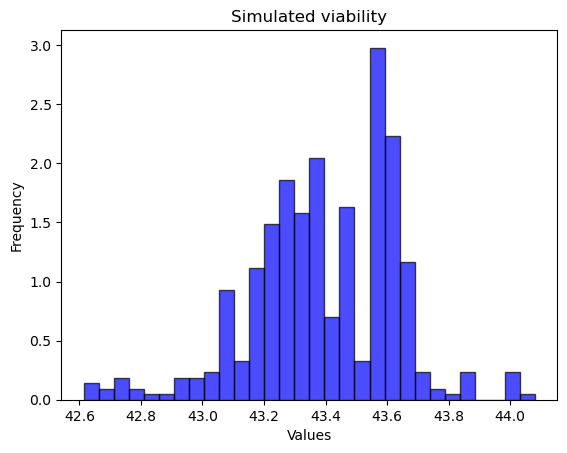

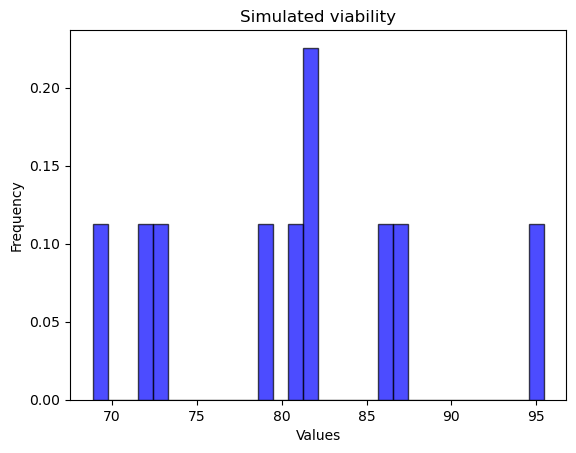

In [10]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

viability = np.loadtxt('../data_output/viability.csv', delimiter=",", skiprows=1, usecols=range(440))
viability_median = np.median(viability, axis=0)

# Create a histogram
plt.hist(viability_median, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Simulated viability')
plt.show()

viability_experimental = pd.read_csv('../../Netlogo_NLCs-CLL/filtered_fused_9patients.csv')
# Create a histogram
plt.hist(viability_experimental['viability'], bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Simulated viability')
plt.show()


Problem

In [27]:
from pymoo.core.problem import Problem

class calibrationProb(Problem):
    def _init_(self):
        super()._init_(n_var = 2,
                       n_obj = 1,
                       xl = np.array([0, 0]),
                       xu = np.array([0, 0]))
        
    def _evaluate(self, out):
        out["F"] = (x[:,0] - x[:,1])**2 #Sum(observed - predicted)**2


NLC_problem = calibrationProb()

Parameter exploration

In [28]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.util.plotting import plot

algorithm_nsga = NSGA2(pop_size=400)

res = minimize(problem= NLC_problem,
               algorithm=algorithm_nsga,
               seed=1,
               verbose=False)

plot(res.X, no_fill=True)

ValueError: negative dimensions are not allowed

In [26]:
import pandas as pd
viability = pd.read_csv('../../../../Downloads/data_output/viability.csv', delimiter=",", skiprows=[15, 16], usecols=range(1, 1393))
concentration = pd.read_csv('../../../../Downloads/data_output/concentration.csv', delimiter=",", skiprows=[15, 16], usecols=range(1, 1393))

In [27]:
samples = pd.read_csv('../data_output/Sensitivity_analysis/sobol_samples.csv', delimiter=",", skiprows=1)
samples = np.array(samples)
tuple(samples[1])
samples.shape[0]

1407

In [31]:
import numpy as np
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool
pop_size = 500
pool = ThreadPool(3)

def model_simulation(input_file_path, replicates, *args):                
    
    viability = np.loadtxt('../data_output/viability.csv', delimiter=",", skiprows=1)
    concentration = np.loadtxt('../data_output/concentration.csv', delimiter=",", skiprows=1)

    return viability, concentration


params = [(("./config/NLC_CLL.xml", 2) + tuple(samples[i])) for i in range(samples.shape[0])]

# Calculate the function values in a parallelized manner and wait until done
results = pool.starmap(model_simulation, params)


In [32]:
viability, concentration = results[1]

In [33]:
from pymoo.core.problem import Problem
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

experimental = np.loadtxt('../../Netlogo_NLCs-CLL/filtered_fused_9patients.csv', delimiter=",", skiprows=1)
viability_exp = experimental[:,1]
concentration_exp = experimental[:,2]
pop_size = 500
pool = ThreadPool(3) # Adjust the number of threads as needed (how many tasks can run concurrently.)
n_replicates = 2

class calibrationProb(Problem):
    def __init__(self):
        super().__init__(n_var = 10,
                       n_obj = 2,
                       xl = np.array([0.9, 0.9, 4e-5, 0.9, 24e-2, 0.9, 91e-2, 0.9, 0.9, 3e-2]),
                       xu = np.array([1.2, 1.2, 6e-5, 1.2, 26e-2, 1.2, 93e-2, 1.2, 1.2, 5e-2]))
        
    def _evaluate(self, x, out):

        # Prepare the parameters for the pool
        params = [(("./config/NLC_CLL.xml", n_replicates) + tuple(x[i])) for i in range(pop_size)]

        # Calculate the function values in a parallelized manner and wait until done
        results = pool.starmap(model_simulation, params)

        #Objective functions
        obj1 = []
        obj2 = []
        for i in range(pop_size):
            viability, concentration = results[i]
            #RMSE of viability
            rmse_viability = np.sqrt(np.sum((viability - viability_exp)**2) / 10) #10 is the total of time points
            obj1.append(rmse_viability)
            #RMSE of concentration
            rmse_concentration = np.sqrt(np.sum((concentration - concentration_exp)**2) / 10) #10 is the total of time points
            obj2.append(rmse_concentration)

        #Stacking objectives to "F" 
        out["F"] = np.column_stack([obj1, obj2])

        pool.close()


NLC_problem = calibrationProb()

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination

algorithm_nsga = NSGA2(pop_size=pop_size)

termination = get_termination("n_gen", 1000)

res = minimize(NLC_problem,
               algorithm_nsga,
               termination,
               seed=1,
               verbose=True)

 
print(res.X)
print(res.F)

np.savetxt('data_output/Space_values.csv', res.X, delimiter=",")
np.savetxt('data_output/Objective_values.csv', res.F, delimiter=",")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      500 |    500 |             - |             -
     2 |     1000 |    500 |  0.000000E+00 |             f
     3 |     1500 |    500 |  0.000000E+00 |             f
     4 |     2000 |    500 |  0.000000E+00 |             f
     5 |     2500 |    500 |  0.000000E+00 |             f
     6 |     3000 |    500 |  0.000000E+00 |             f
     7 |     3500 |    500 |  0.000000E+00 |             f
     8 |     4000 |    500 |  0.000000E+00 |             f
     9 |     4500 |    500 |  0.000000E+00 |             f
    10 |     5000 |    500 |  0.000000E+00 |             f
    11 |     5500 |    500 |  0.000000E+00 |             f
    12 |     6000 |    500 |  0.000000E+00 |             f
    13 |     6500 |    500 |  0.000000E+00 |             f
    14 |     7000 |    500 |  0.000000E+00 |             f
    15 |     7500 |    500 |  0.000000E+00 |             f
    16 |     8000 |    500 |  0.000000E+00 |            

KeyboardInterrupt: 

In [8]:
import xml.etree.ElementTree as ET
import subprocess
import pandas as pd
import sys
import numpy as np
import os
import random
from multiprocessing import Pool
from pymoo.core.problem import Problem
from multiprocessing.pool import ThreadPool
from collect_data import collect
from merge_data import merge

df = collect('../config/NLC_CLL.xml')



Error @ pyMCDSts.__init__ : this is not a path! could not load output/.


IndexError: list index out of range